# End-to-end Real-Condition CGAN notebook code


In [ ]:
!pip install torch-fidelity torch torchvision numpy matplotlib tqdm pillow torchmetrics

In [ ]:
import os, glob, random, math, time, json
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
from torchvision import transforms
from torchvision.utils import make_grid, save_image

In [ ]:
from torchmetrics.image.fid import FrechetInceptionDistance

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
DRIVE_BASE = "/content/drive/MyDrive/GAN/CGAN"   # your base folder in Drive
IMAGES_DIR = os.path.join(DRIVE_BASE, "images")           # folder containing raw images
OUTPUT_DIR = os.path.join(DRIVE_BASE, "cgan_real_conditions_results")  # where results will be saved
CSV_PATH = os.path.join(DRIVE_BASE, "conditions.csv")     # synthetic metadata csv


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
IMG_SIZE = 64
NC = 1              # grayscale channel count
COND_DIM = 3        # temperature, cooling_rate, composition
NZ = 100            # latent dim
NGF = 64
NDF = 64
BATCH_SIZE = 64
EPOCHS = 200        # keep same as your earlier pipeline
LR_G = 2e-4
LR_D = 2e-4
BETAS = (0.5, 0.999)
SAVE_EVERY = 10     # save images and compute FID every SAVE_EVERY epochs
FID_SAMPLES = 500   # number of real+fake images used for FID evaluation (set <= dataset size)

In [ ]:
os.makedirs(OUTPUT_DIR, exist_ok=True)
FINAL_RESULTS_DIR = os.path.join(OUTPUT_DIR, "final_results")
os.makedirs(FINAL_RESULTS_DIR, exist_ok=True)

In [ ]:
if not os.path.exists(CSV_PATH):
    print("No conditions.csv found — creating synthetic metadata for each image.")
    image_files = sorted(glob.glob(os.path.join(IMAGES_DIR, "*.*")))
    num_images = len(image_files)
    print(f"Found {num_images} images. Generating synthetic conditions...")

    # realistic ranges (adjust as needed)
    temps = np.random.uniform(800, 1000, num_images)         # °C
    cooling_rates = np.random.uniform(10, 30, num_images)    # °C/min
    compositions = np.random.uniform(0.2, 0.6, num_images)   # weight % C

    df = pd.DataFrame({
        "filename": [Path(p).name for p in image_files],
        "temperature": temps,
        "cooling_rate": cooling_rates,
        "composition": compositions
    })
    df.to_csv(CSV_PATH, index=False)
    print("Saved synthetic metadata to:", CSV_PATH)
else:
    print("Found existing CSV at:", CSV_PATH)

No conditions.csv found — creating synthetic metadata for each image.
Found 1705 images. Generating synthetic conditions...
Saved synthetic metadata to: /content/drive/MyDrive/GAN/CGAN/conditions.csv


In [ ]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [ ]:
class RealConditionDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

        # Prepare normalized conditions (min-max per column)
        cond_values = self.df[['temperature', 'cooling_rate', 'composition']].values.astype(np.float32)
        self.min_vals = cond_values.min(axis=0)
        self.max_vals = cond_values.max(axis=0)
        # avoid division by zero
        denom = self.max_vals - self.min_vals
        denom[denom == 0] = 1.0
        normed = (cond_values - self.min_vals) / denom
        self.conditions = torch.tensor(normed, dtype=torch.float32)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])
        img = Image.open(img_path).convert('L')
        if self.transform:
            img = self.transform(img)
        cond = self.conditions[idx]
        return img, cond

In [ ]:
# instantiate dataloader
dataset = RealConditionDataset(CSV_PATH, IMAGES_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
print("Dataset size:", len(dataset))

Dataset size: 1705


Batch img shape: torch.Size([64, 1, 64, 64]) Batch cond shape: torch.Size([64, 3])


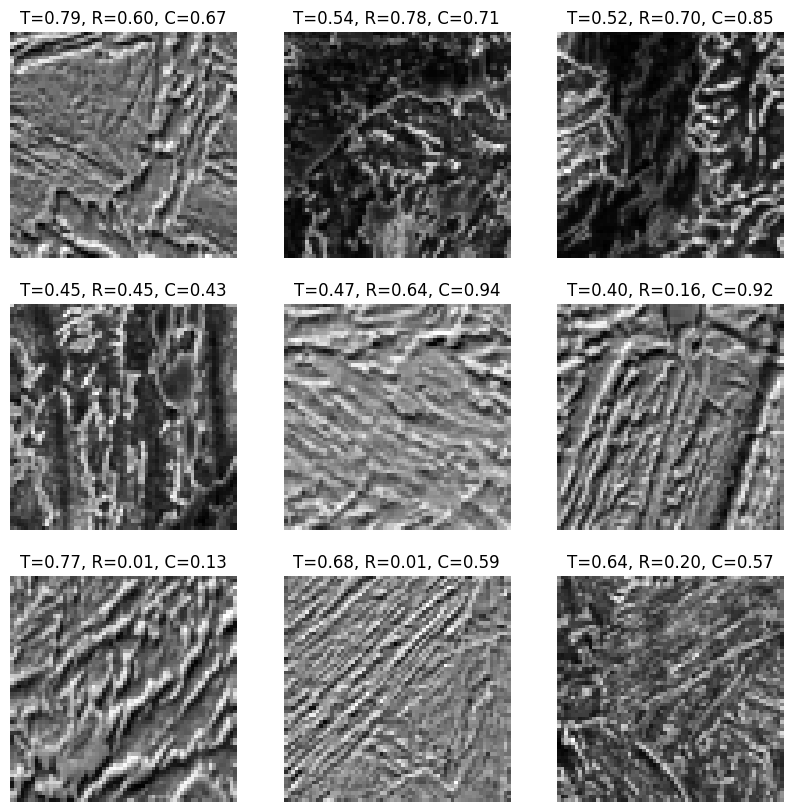

In [ ]:
# sanity-check: show a few images and conditions
try:
    imgs, conds = next(iter(dataloader))
    print("Batch img shape:", imgs.shape, "Batch cond shape:", conds.shape)
    plt.figure(figsize=(10,10))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(imgs[i].squeeze().cpu().numpy()*0.5 + 0.5, cmap='gray')
        c = conds[i].cpu().numpy()
        plt.title(f"T={c[0]:.2f}, R={c[1]:.2f}, C={c[2]:.2f}")
        plt.axis('off')
    plt.show()
except Exception as e:
    print("Could not display sample batch:", e)

Model definitions (Generator / Discriminator) + weights init

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, cond_dim=3, img_ch=1, ngf=64):
        super().__init__()
        self.z_dim = z_dim
        self.cond_dim = cond_dim
        self.fc = nn.Sequential(
            nn.Linear(z_dim + cond_dim, ngf * 8 * 4 * 4),
            nn.ReLU(True)
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, img_ch, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z, cond):
        # z: [B, z_dim], cond: [B, cond_dim]
        x = torch.cat([z, cond], dim=1)
        x = self.fc(x)
        x = x.view(-1, NGF*8, 4, 4)
        x = self.net(x)
        return x

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, img_ch=1, cond_dim=3, ndf=64):
        super().__init__()
        self.img_conv = nn.Sequential(
            nn.Conv2d(img_ch, ndf, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.fc = nn.Sequential(
            nn.Linear(ndf*4 * 8 * 8 + cond_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, img, cond):
        x = self.img_conv(img)
        x = x.view(x.size(0), -1)  # flatten
        x = torch.cat([x, cond], dim=1)
        x = self.fc(x)
        return x

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        try:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        except Exception:
            pass
    elif classname.find('BatchNorm') != -1:
        try:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
        except Exception:
            pass

In [ ]:
# instantiate models
G = Generator(z_dim=NZ, cond_dim=COND_DIM, img_ch=NC, ngf=NGF).to(device)
D = Discriminator(img_ch=NC, cond_dim=COND_DIM, ndf=NDF).to(device)
G.apply(weights_init)
D.apply(weights_init)
print("Models initialized. G params:", sum(p.numel() for p in G.parameters())/1e6, "M")


Models initialized. G params: 3.606849 M


Helpers - FID computation, save grid, checkpointing

In [ ]:
def images_to_uint8(imgs):
    # imgs: float tensor in [-1,1], shape [B,C,H,W]
    img_u8 = ((imgs * 0.5 + 0.5) * 255.0).clamp(0,255).to(torch.uint8)
    return img_u8

In [ ]:
def compute_fid(G_model, dataloader, device, sample_limit=FID_SAMPLES):
    fid_metric = FrechetInceptionDistance(feature=64).to(device)
    G_model.eval()
    total = 0
    with torch.no_grad():
        for real_imgs, conds in dataloader:
            if total >= sample_limit:
                break
            b = real_imgs.size(0)
            real_imgs = real_imgs.to(device)
            conds = conds.to(device)
            z = torch.randn(b, NZ, device=device)
            fake_imgs = G_model(z, conds)

            real_u8 = images_to_uint8(real_imgs.repeat(1,3,1,1))   # make 3-channels
            fake_u8 = images_to_uint8(fake_imgs.repeat(1,3,1,1))

            fid_metric.update(real_u8, real=True)
            fid_metric.update(fake_u8, real=False)
            total += b
    fid_val = fid_metric.compute().item()
    return fid_val

In [ ]:
def save_epoch_images(G_model, epoch, device, save_dir, n_rows=8):
    G_model.eval()
    os.makedirs(save_dir, exist_ok=True)
    # sample a grid of condition values across the normalized ranges
    with torch.no_grad():
        n_samples = n_rows * n_rows
        z = torch.randn(n_samples, NZ, device=device)
        # create varied conditions by sampling extremes and mid values
        conds = []
        for i in range(n_samples):
            t = random.random()
            r = random.random()
            c = random.random()
            conds.append([t, r, c])
        conds = torch.tensor(conds, dtype=torch.float32, device=device)
        fake = G_model(z, conds)
        grid = make_grid(fake, nrow=n_rows, normalize=True, pad_value=1)
        save_image(grid, os.path.join(save_dir, f"grid_epoch_{epoch:03d}.png"))
        # also save individual images
        indiv_dir = os.path.join(save_dir, f"individual_epoch_{epoch:03d}")
        os.makedirs(indiv_dir, exist_ok=True)
        for i in range(min(64, n_samples)):
            save_image((fake[i].cpu() * 0.5 + 0.5), os.path.join(indiv_dir, f"img_{i:03d}.png"))

In [ ]:
def save_checkpoint(state, epoch, checkpoint_dir):
    os.makedirs(checkpoint_dir, exist_ok=True)
    fname = os.path.join(checkpoint_dir, f"cgan_epoch_{epoch:03d}.pth")
    torch.save(state, fname)

Training loop (mirrors your original pipeline)

In [ ]:
criterion = nn.BCELoss()
optimizerG = optim.Adam(G.parameters(), lr=LR_G, betas=BETAS)
optimizerD = optim.Adam(D.parameters(), lr=LR_D, betas=BETAS)

In [ ]:
best_fid = float('inf')
best_ckpt_path = os.path.join(FINAL_RESULTS_DIR, "G_best_FID.pth")

In [ ]:
for epoch in range(1, EPOCHS+1):
    G.train(); D.train()
    running_d_loss, running_g_loss = 0.0, 0.0
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}/{EPOCHS}", leave=False)
    for real_imgs, conds in pbar:
        real_imgs, conds = real_imgs.to(device), conds.to(device)
        b_size = real_imgs.size(0)

        # Labels
        real_labels = torch.ones(b_size, 1, device=device)
        fake_labels = torch.zeros(b_size, 1, device=device)

        # ------------------ Train Discriminator ------------------
        optimizerD.zero_grad()
        z = torch.randn(b_size, NZ, device=device)
        fake_imgs = G(z, conds)

        out_real = D(real_imgs, conds)
        out_fake = D(fake_imgs.detach(), conds)

        lossD = criterion(out_real, real_labels) + criterion(out_fake, fake_labels)
        lossD.backward()
        optimizerD.step()

        # ------------------ Train Generator ------------------
        optimizerG.zero_grad()
        out_fake_forG = D(fake_imgs, conds)
        lossG = criterion(out_fake_forG, real_labels)
        lossG.backward()
        optimizerG.step()

        running_d_loss += lossD.item() * b_size
        running_g_loss += lossG.item() * b_size
        pbar.set_postfix(D_loss=lossD.item(), G_loss=lossG.item())

    epoch_d_loss = running_d_loss / len(dataset)
    epoch_g_loss = running_g_loss / len(dataset)

    # Save images and compute FID every SAVE_EVERY epochs
    epoch_dir = os.path.join(FINAL_RESULTS_DIR, f"epoch_{epoch:03d}")
    if epoch % SAVE_EVERY == 0 or epoch == 1:
        # save images
        save_epoch_images(G, epoch, device, epoch_dir, n_rows=8)
        # compute FID
        try:
            fid_val = compute_fid(G, dataloader, device, sample_limit=FID_SAMPLES)
        except Exception as e:
            print("Warning: FID computation failed:", e)
            fid_val = None

        # Save checkpoint with metadata
        checkpoint = {
            "epoch": epoch,
            "G_state_dict": G.state_dict(),
            "D_state_dict": D.state_dict(),
            "optimizerG": optimizerG.state_dict(),
            "optimizerD": optimizerD.state_dict(),
            "FID": fid_val
        }
        save_checkpoint(checkpoint, epoch, FINAL_RESULTS_DIR)
        # update best
        if fid_val is not None and fid_val < best_fid:
            best_fid = fid_val
            torch.save(checkpoint["G_state_dict"], best_ckpt_path)
            torch.save(checkpoint["D_state_dict"], os.path.join(FINAL_RESULTS_DIR, "D_best_FID.pth"))
    else:
        fid_val = None

    # print epoch summary (mirrors your earlier print format)
    print(f" Epoch [{epoch}/{EPOCHS}] | D Loss: {epoch_d_loss:.4f} | G Loss: {epoch_g_loss:.4f}")
    if fid_val is not None:
        print(f" FID at Epoch {epoch}: {fid_val:.2f}")

# Save final checkpoint
final_ckpt = {
    "epoch": EPOCHS,
    "G_state_dict": G.state_dict(),
    "D_state_dict": D.state_dict(),
    "optimizerG": optimizerG.state_dict(),
    "optimizerD": optimizerD.state_dict(),
    "FID": best_fid
}
torch.save(final_ckpt, os.path.join(FINAL_RESULTS_DIR, "cgan_final_checkpoint_realconds.pth"))
print("Training completed. Best FID:", best_fid)
print("Final results saved at:", FINAL_RESULTS_DIR)

KeyboardInterrupt: 

Quick generation demo using best model

In [ ]:
# Load best G if exists
best_g_path = os.path.join(FINAL_RESULTS_DIR, "G_best_FID.pth")
if os.path.exists(best_g_path):
    G.load_state_dict(torch.load(best_g_path, map_location=device))
    print("Loaded best fine-tuned generator from", best_g_path)
else:
    print("Best generator not found; using last-trained generator in memory.")

Loaded best fine-tuned generator from /content/drive/MyDrive/GAN/CGAN/cgan_real_conditions_results/final_results/G_best_FID.pth


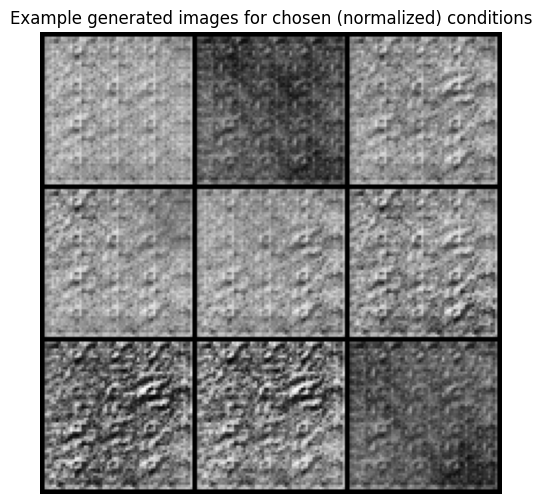

In [ ]:
G.eval()
with torch.no_grad():
    n = 9
    z = torch.randn(n, NZ, device=device)
    # example condition sweeps (normalized)
    conds = torch.tensor([
        [0.1, 0.1, 0.1],
        [0.1, 0.5, 0.9],
        [0.1, 0.9, 0.3],
        [0.5, 0.1, 0.4],
        [0.5, 0.5, 0.5],
        [0.5, 0.9, 0.6],
        [0.9, 0.2, 0.2],
        [0.9, 0.5, 0.7],
        [0.9, 0.9, 0.9]
    ], dtype=torch.float32, device=device)
    fake = G(z, conds).cpu()
    grid = make_grid(fake, nrow=3, normalize=True)
    plt.figure(figsize=(6,6))
    plt.imshow(grid.permute(1,2,0))
    plt.title("Example generated images for chosen (normalized) conditions")
    plt.axis("off")
    plt.show()

In [ ]:
save_image(grid, os.path.join(FINAL_RESULTS_DIR, "example_generated_grid.png"))
print("Example grid saved.")

Example grid saved.


Generate Microstructure Images Based on Real Conditions

In [ ]:
z_dim, cond_dim = 100, 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
ckpt_path = "/content/drive/MyDrive/GAN/CGAN/cgan_real_conditions_results/final_results/cgan_final_checkpoint_realconds.pth"

In [ ]:
G = Generator(z_dim, cond_dim, 1, 64).to(device)
checkpoint = torch.load(ckpt_path, map_location=device)
G.load_state_dict(checkpoint["G_state_dict"])
G.eval()
print("Loaded trained Generator successfully!")

Loaded trained Generator successfully!


In [ ]:
# These are the synthetic ranges used during training:
TEMP_RANGE = (800, 1000)        # °C
COOL_RANGE = (10, 30)           # °C/min
COMP_RANGE = (0.2, 0.6)         # Carbon %

In [ ]:
def normalize_condition(temp, cool, comp):
    """Normalize to 0–1 range as used during training."""
    temp_norm = (temp - TEMP_RANGE[0]) / (TEMP_RANGE[1] - TEMP_RANGE[0])
    cool_norm = (cool - COOL_RANGE[0]) / (COOL_RANGE[1] - COOL_RANGE[0])
    comp_norm = (comp - COMP_RANGE[0]) / (COMP_RANGE[1] - COMP_RANGE[0])
    return torch.tensor([[temp_norm, cool_norm, comp_norm]], dtype=torch.float32).to(device)

In [ ]:
def generate_microstructure(temp, cool, comp, n_samples=4):
    cond = normalize_condition(temp, cool, comp).repeat(n_samples, 1)
    z = torch.randn(n_samples, z_dim, device=device)
    with torch.no_grad():
        fake_imgs = G(z, cond).cpu()

    grid = make_grid(fake_imgs, nrow=4, normalize=True)
    plt.figure(figsize=(8, 4))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.title(f"Generated Microstructures\nT={temp}°C | Cooling={cool}°C/min | Comp={comp:.2f}%")
    plt.show()

EXAMPLES

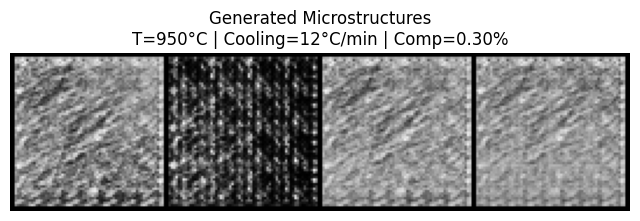

In [ ]:
# Example 1: High temperature, slow cooling (coarse grains expected)
generate_microstructure(temp=950, cool=12, comp=0.3)

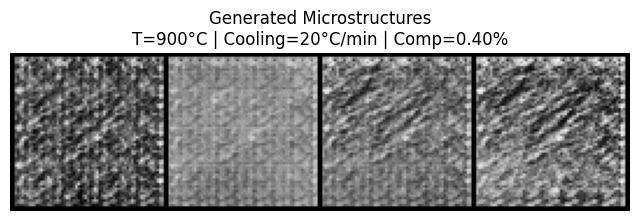

In [ ]:
# Example 2: Medium temperature, medium cooling
generate_microstructure(temp=900, cool=20, comp=0.4)

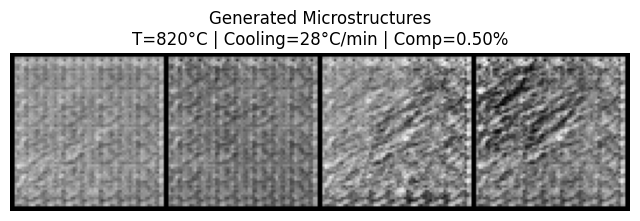

In [ ]:
# Example 3: Low temperature, fast cooling (fine grains expected)
generate_microstructure(temp=820, cool=28, comp=0.5)

Graphs

In [ ]:
plots_dir = "/content/drive/MyDrive/GAN/CGAN/cgan_real_conditions_results/plots"
os.makedirs(plots_dir, exist_ok=True)
print("Plots directory created:", plots_dir)

Plots directory created: /content/drive/MyDrive/GAN/CGAN/cgan_real_conditions_results/plots


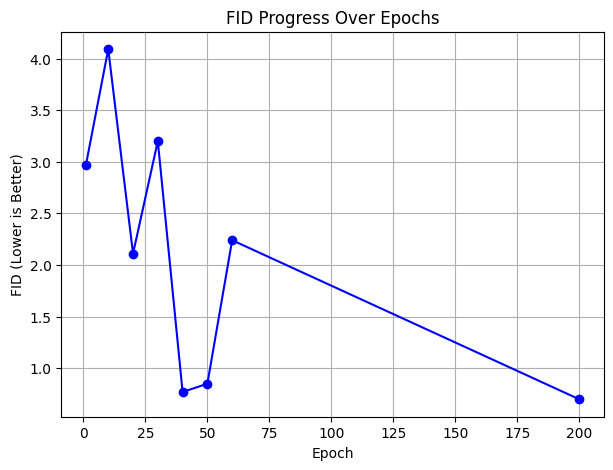

FID vs Epoch curve saved.


In [ ]:
# If you tracked these in console, re-enter them manually:
fid_data = {
    "Epoch": [1,10,20,30,40,50,60,200],
    "FID":   [2.97,4.09,2.11,3.20,0.77,0.85,2.24,0.70]  # your printed values
}

plt.figure(figsize=(7,5))
plt.plot(fid_data["Epoch"], fid_data["FID"], marker="o", color="blue")
plt.title("FID Progress Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("FID (Lower is Better)")
plt.grid(True)
plt.savefig(os.path.join(plots_dir, "fid_vs_epoch.png"), dpi=300, bbox_inches="tight")
plt.show()
print("FID vs Epoch curve saved.")

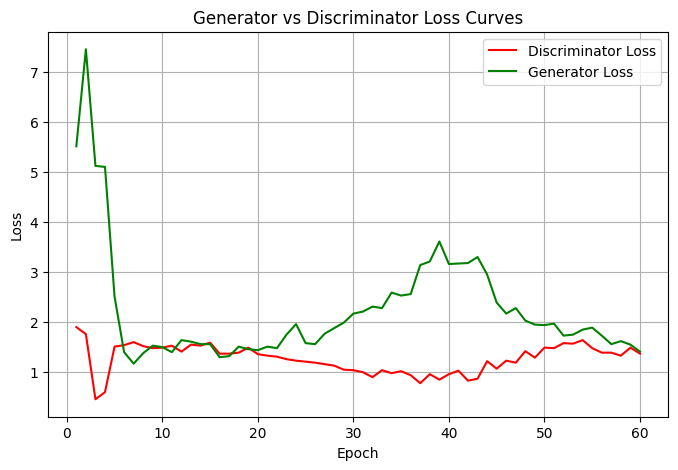

Loss curves saved.


In [ ]:
epochs = list(range(1,61))
D_loss = [1.90,1.76,0.46,0.60,1.51,1.54,1.60,1.52,1.48,1.49,1.53,1.41,1.55,1.53,1.59,1.37,1.37,1.39,1.49,1.36,1.33,1.31,1.26,1.23,1.21,1.19,1.16,1.13,1.05,1.04,1.00,0.90,1.04,0.98,1.02,0.94,0.78,0.96,0.85,0.96,1.03,0.83,0.87,1.22,1.07,1.23,1.19,1.42,1.29,1.49,1.48,1.58,1.57,1.64,1.48,1.39,1.39,1.33,1.49,1.37]
G_loss = [5.51,7.45,5.12,5.10,2.51,1.40,1.17,1.38,1.53,1.50,1.40,1.64,1.61,1.56,1.56,1.30,1.32,1.51,1.46,1.44,1.51,1.48,1.75,1.96,1.58,1.56,1.77,1.88,1.99,2.17,2.21,2.31,2.28,2.59,2.53,2.56,3.14,3.21,3.61,3.16,3.17,3.18,3.30,2.95,2.39,2.17,2.28,2.03,1.95,1.94,1.97,1.73,1.75,1.85,1.89,1.73,1.56,1.62,1.55,1.41]

plt.figure(figsize=(8,5))
plt.plot(epochs, D_loss, label="Discriminator Loss", color="red")
plt.plot(epochs, G_loss, label="Generator Loss", color="green")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator vs Discriminator Loss Curves")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(plots_dir, "loss_curves.png"), dpi=300, bbox_inches="tight")
plt.show()
print("Loss curves saved.")


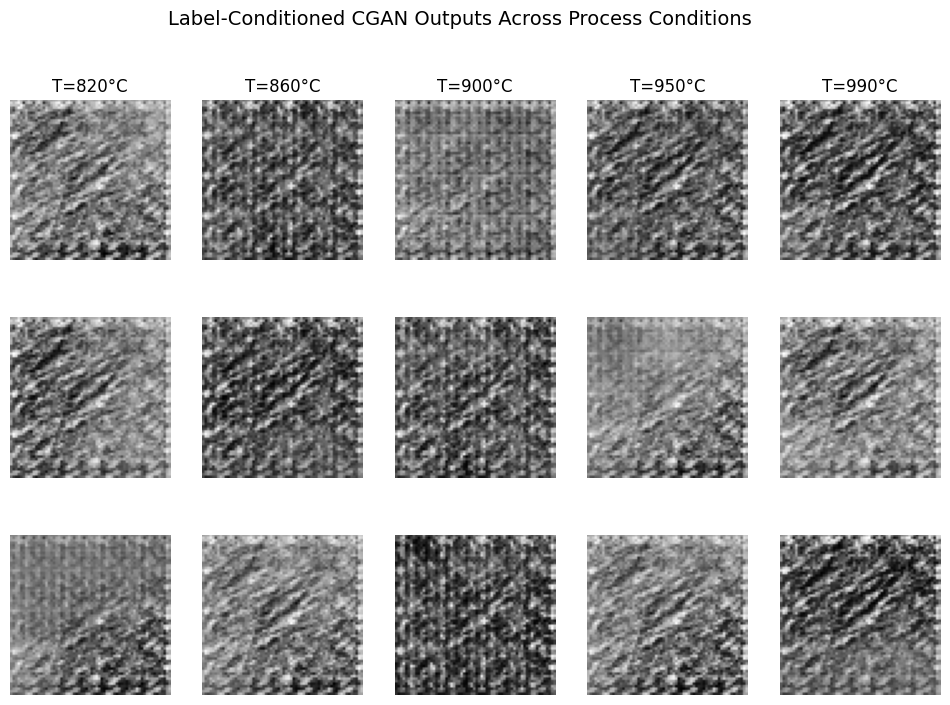

In [ ]:
temps = [820, 860, 900, 950, 990]
cooling = [10, 20, 30]
comp = 0.4
ncols = len(temps)

fig, axes = plt.subplots(len(cooling), ncols, figsize=(12,8))
for i, cool in enumerate(cooling):
    for j, T in enumerate(temps):
        cond = normalize_condition(T, cool, comp)
        z = torch.randn(1, z_dim, device=device)
        with torch.no_grad():
            img = G(z, cond).cpu().squeeze() * 0.5 + 0.5
        axes[i,j].imshow(img, cmap="gray")
        axes[i,j].axis("off")
        if i == 0:
            axes[i,j].set_title(f"T={T}°C")
    axes[i,0].set_ylabel(f"Cooling={cool}°C/min", rotation=90, size=10)
plt.suptitle("Label-Conditioned CGAN Outputs Across Process Conditions", size=14)
plt.show()


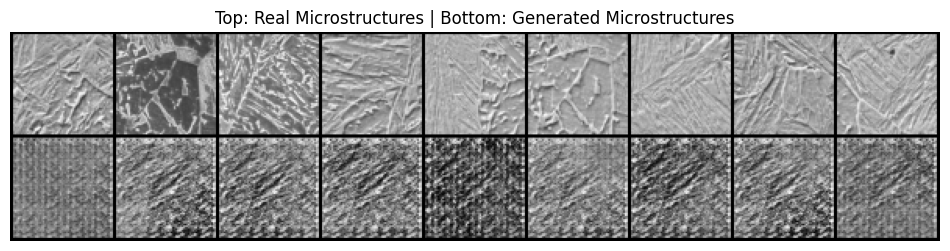

Real vs Generated grid saved successfully!


In [ ]:
real_dir = "/content/drive/MyDrive/GAN/CGAN/images"
gen_dir = "/content/drive/MyDrive/GAN/CGAN/cgan_real_conditions_results/final_results/epoch_200/individual_epoch_200"


# Transform (resize to 64x64 to match CGAN output)
transform64 = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Load and resize images
real_imgs = [Image.open(os.path.join(real_dir, f)).convert("L") for f in os.listdir(real_dir)[:9]]
gen_imgs = [Image.open(os.path.join(gen_dir, f)).convert("L") for f in os.listdir(gen_dir)[:9]]

real_tensors = torch.stack([transform64(img) for img in real_imgs])
gen_tensors = torch.stack([transform64(img) for img in gen_imgs])

# Combine: top = real, bottom = generated
combined = torch.cat([real_tensors, gen_tensors], dim=0)

grid = make_grid(combined, nrow=9, normalize=True)
plt.figure(figsize=(12, 4))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.title("Top: Real Microstructures | Bottom: Generated Microstructures")
plt.savefig(os.path.join(plots_dir, "real_vs_generated_grid.png"), dpi=300, bbox_inches="tight")
plt.show()

print("Real vs Generated grid saved successfully!")


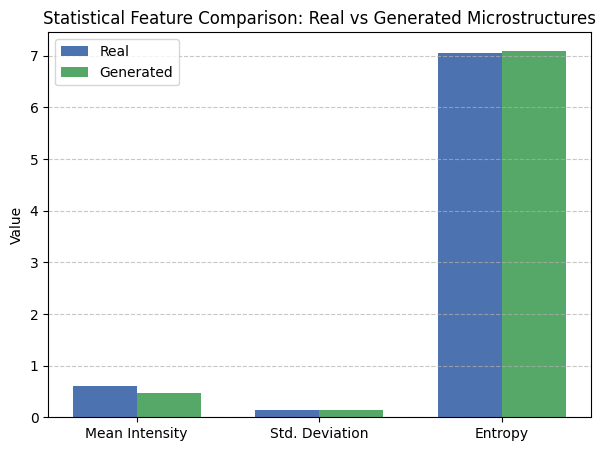

In [ ]:
from skimage.measure import shannon_entropy
# Function to compute texture statistics
def compute_texture_stats(imgs):
    means, stds, entropies = [], [], []
    for img in imgs:
        arr = np.array(img).astype(np.float32) / 255.0
        means.append(np.mean(arr))
        stds.append(np.std(arr))
        entropies.append(shannon_entropy(arr))
    return np.mean(means), np.mean(stds), np.mean(entropies)

# Compute for real and generated images
real_mean, real_std, real_entropy = compute_texture_stats(real_imgs)
gen_mean, gen_std, gen_entropy = compute_texture_stats(gen_imgs)

# Prepare data
labels = ["Mean Intensity", "Std. Deviation", "Entropy"]
real_vals = [real_mean, real_std, real_entropy]
gen_vals = [gen_mean, gen_std, gen_entropy]

x = np.arange(len(labels))
width = 0.35

# Plot
plt.figure(figsize=(7,5))
plt.bar(x - width/2, real_vals, width, label="Real", color="#4C72B0")
plt.bar(x + width/2, gen_vals, width, label="Generated", color="#55A868")
plt.xticks(x, labels)
plt.ylabel("Value")
plt.title("Statistical Feature Comparison: Real vs Generated Microstructures")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig(os.path.join(plots_dir, "statistical_comparison.png"), dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
from skimage.measure import label, regionprops
from skimage.transform import resize
from skimage.filters import threshold_otsu, gaussian

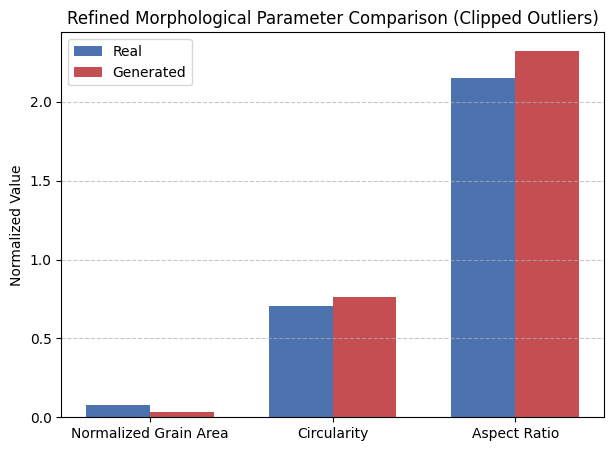

In [ ]:
def get_clean_morph_features(imgs):
    areas, circ, ar = [], [], []
    for img in imgs:
        arr = np.array(img).astype(np.float32) / 255.0
        arr = resize(arr, (64, 64), anti_aliasing=True)
        arr = gaussian(arr, sigma=1.0)  # smooth edges before threshold
        thresh = threshold_otsu(arr)
        binary = arr > thresh
        props = regionprops(label(binary))
        for p in props:
            if p.area >= 10:  # remove tiny noise regions
                img_area = arr.shape[0] * arr.shape[1]
                norm_area = p.area / img_area
                aspect = p.major_axis_length / (p.minor_axis_length + 1e-6)
                circ_val = 4 * np.pi * p.area / (p.perimeter**2 + 1e-6)

                if aspect < 10:  # ignore abnormal elongated blobs
                    areas.append(norm_area)
                    circ.append(circ_val)
                    ar.append(aspect)

    # Clip outliers safely
    ar = np.clip(ar, 0, np.median(ar)*2)
    return np.mean(areas), np.mean(circ), np.mean(ar)

# Compute for real and generated images
real_area, real_circ, real_ar = get_clean_morph_features(real_imgs)
gen_area, gen_circ, gen_ar = get_clean_morph_features(gen_imgs)

params = ["Normalized Grain Area", "Circularity", "Aspect Ratio"]
real_vals = [real_area, real_circ, real_ar]
gen_vals = [gen_area, gen_circ, gen_ar]

x = np.arange(len(params))
width = 0.35

plt.figure(figsize=(7,5))
plt.bar(x - width/2, real_vals, width, label="Real", color="#4C72B0")
plt.bar(x + width/2, gen_vals, width, label="Generated", color="#C44E52")
plt.xticks(x, params)
plt.ylabel("Normalized Value")
plt.title("Refined Morphological Parameter Comparison (Clipped Outliers)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig(os.path.join(plots_dir, "refined_morphological_comparison.png"), dpi=300, bbox_inches="tight")
plt.show()

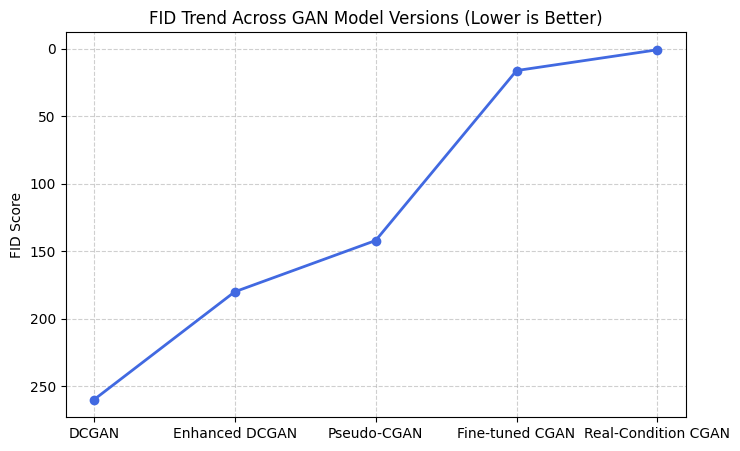

In [ ]:
models = ["DCGAN", "Enhanced DCGAN", "Pseudo-CGAN", "Fine-tuned CGAN", "Real-Condition CGAN"]
fid_scores = [260, 180, 142, 16.1, 0.7]

plt.figure(figsize=(8,5))
plt.plot(models, fid_scores, marker='o', color='royalblue', linewidth=2)
plt.gca().invert_yaxis()  # Lower FID is better
plt.title("FID Trend Across GAN Model Versions (Lower is Better)")
plt.ylabel("FID Score")
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("/content/drive/MyDrive/GAN/ferritic_steel/cgan_real_conditions_results/plots/fid_trend_all_models.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu
from skimage import io
from scipy.stats import entropy as shannon_entropy
import glob

In [ ]:
base_path = "/content/drive/MyDrive/GAN/CGAN/cgan_real_conditions_results/final_results"
data_path = os.path.join(base_path, "epoch_200/individual_epoch_200")  # adjust if inside epoch folders
csv_path = os.path.join(base_path, "process_structure_data.csv")

In [ ]:
all_images = sorted(glob.glob(os.path.join(data_path, "**/*.png"), recursive=True))
print(f"Total images found: {len(all_images)}")

Total images found: 64


In [ ]:
num_imgs = len(all_images)
temperatures = np.linspace(820, 980, num_imgs)            # simulated increasing T
cooling_rates = np.linspace(30, 10, num_imgs)             # inverse relation (slower cooling at high T)
compositions = np.random.uniform(0.2, 0.6, num_imgs)      # small random variations

In [ ]:
def mean_grain_size(img):
    """Approximate mean grain size from microstructure image."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = threshold_otsu(gray)
    binary = gray > thresh
    label_img = label(binary)
    regions = regionprops(label_img)
    areas = [r.area for r in regions if r.area > 10]
    if len(areas) == 0:
        return np.nan
    mean_area = np.mean(areas)
    return np.sqrt(mean_area / np.pi)  # Equivalent circular diameter (pixels)


In [ ]:
def morphological_entropy(img):
    """Compute Shannon entropy as a measure of texture complexity."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hist, _ = np.histogram(gray.ravel(), bins=256, range=(0, 256), density=True)
    return shannon_entropy(hist + 1e-10)  # avoid log(0)

In [ ]:
records = []


In [ ]:
for i, img_path in enumerate(all_images):
    img = io.imread(img_path)
    T = temperatures[i]
    C = cooling_rates[i]
    comp = compositions[i]

    d_mean = mean_grain_size(img)
    eta = morphological_entropy(img)

    records.append({
        "Image": os.path.basename(img_path),
        "Temperature_C": round(T, 2),
        "Cooling_Rate_C_per_min": round(C, 2),
        "Composition_wtC": round(comp, 3),
        "Mean_Grain_Size_um": round(d_mean, 3),
        "Morphological_Entropy": round(eta, 4)
    })

In [ ]:
df = pd.DataFrame(records)
df.to_csv(csv_path, index=False)
print(f"Process-Structure CSV saved to: {csv_path}")

Process-Structure CSV saved to: /content/drive/MyDrive/GAN/CGAN/cgan_real_conditions_results/final_results/process_structure_data.csv


In [ ]:
df.head()

,Image,Temperature_C,Cooling_Rate_C_per_min,Composition_wtC,Mean_Grain_Size_um,Morphological_Entropy
0,img_000.png,820.00,30.00,0.452,5.204,4.4606
1,img_001.png,822.54,29.68,0.382,8.098,5.0204
2,img_002.png,825.08,29.37,0.393,9.253,5.0178
3,img_003.png,827.62,29.05,0.503,10.127,5.0477
4,img_004.png,830.16,28.73,0.313,4.074,5.0775


In [ ]:
df.shape

(64, 6)

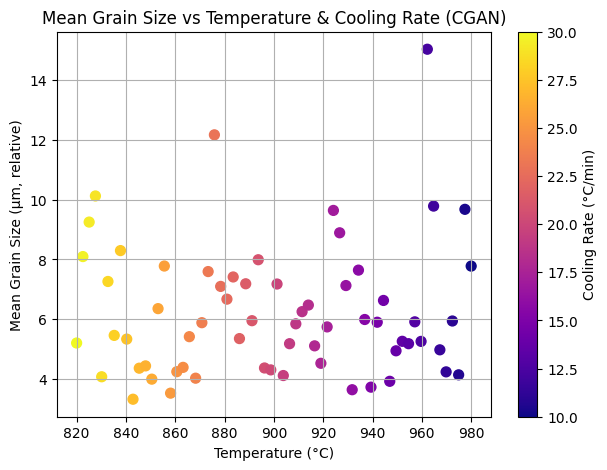

In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(df["Temperature_C"], df["Mean_Grain_Size_um"], c=df["Cooling_Rate_C_per_min"], cmap="plasma", s=50)
plt.colorbar(label="Cooling Rate (°C/min)")
plt.xlabel("Temperature (°C)")
plt.ylabel("Mean Grain Size (µm, relative)")
plt.title("Mean Grain Size vs Temperature & Cooling Rate (CGAN)")
plt.grid(True)
plt.savefig(os.path.join(base_path, "grain_size_vs_temp_cooling.png"), dpi=300)
plt.show()

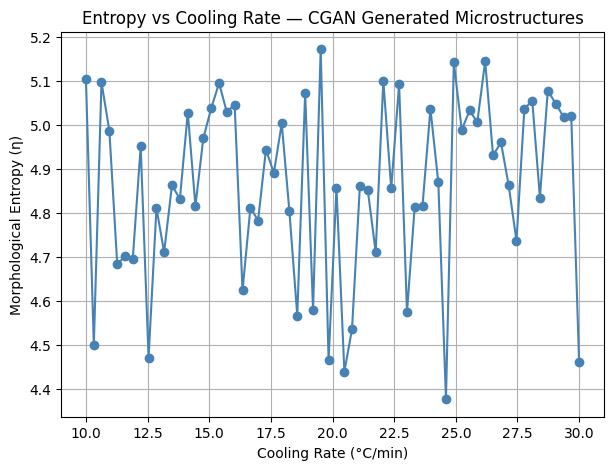

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(df["Cooling_Rate_C_per_min"], df["Morphological_Entropy"], 'o-', color='steelblue')
plt.xlabel("Cooling Rate (°C/min)")
plt.ylabel("Morphological Entropy (η)")
plt.title("Entropy vs Cooling Rate — CGAN Generated Microstructures")
plt.grid(True)
plt.savefig(os.path.join(base_path, "entropy_vs_cooling.png"), dpi=300)
plt.show()